<h1>3. Exploratory Data Analysis</h1>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics
from prettytable import PrettyTable
from sklearn.metrics import r2_score
from tqdm import tqdm
import lightgbm as lgb
from scipy.sparse import hstack
from datetime import datetime, timedelta
import timeit

In [2]:
def describe_data(filename):
    '''The gives all the details of the file'''
    
    path = r"C:\MyWorld\Documents\Study\Non_COre\Machine Learning\Applied AI\Assignments\case_study"
    df = pd.read_csv('{0}/{1}'.format(path,filename))
    print("Shape of the data: ",df.shape)
    print("Columns datatype : ")
    print(df.info())
    print("nans in the data: ")
    print(df.isna().sum())
    print("describe the data: ")
    print(df.describe())
    if 'timestamp' in df.columns.values: 
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

<h2>3.1. Reading weather_train data</h2>

In [3]:
#reading weather_train.csv
df_weather_train = describe_data('weather_train.csv')

Shape of the data:  (139773, 9)
Columns datatype : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB
None
nans in the data: 
site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_d

<h3>3.1.1. Time stamp alignment of df_weather_train</h3>

- Timestamps of weather_train are from diffrent time zones. They are aligned to match timestamps for further processing

In [4]:
#getting useful data from timestamp
df_weather_train['hour'] = df_weather_train['timestamp'].dt.hour

In [5]:
def mean_site_temp(df):
    '''Plots mean temperature of the site in hourly basis'''
    df_temp = df.groupby(['site_id','hour'])['air_temperature'].mean().reset_index()
    plt.figure(figsize=(25, 15))
    for site in range(0,16):
        ax = plt.subplot(4, 4, site + 1)
        plt.plot(df_temp.loc[df_temp['site_id']==site].hour,df_temp.loc[df_temp['site_id']==site].air_temperature)
        ax.set_title(f'site {site} Mean Temperature in a day')
    plt.show()

- Mean hourly temperatature is plotted for all the 16 sites ti check for timezones.

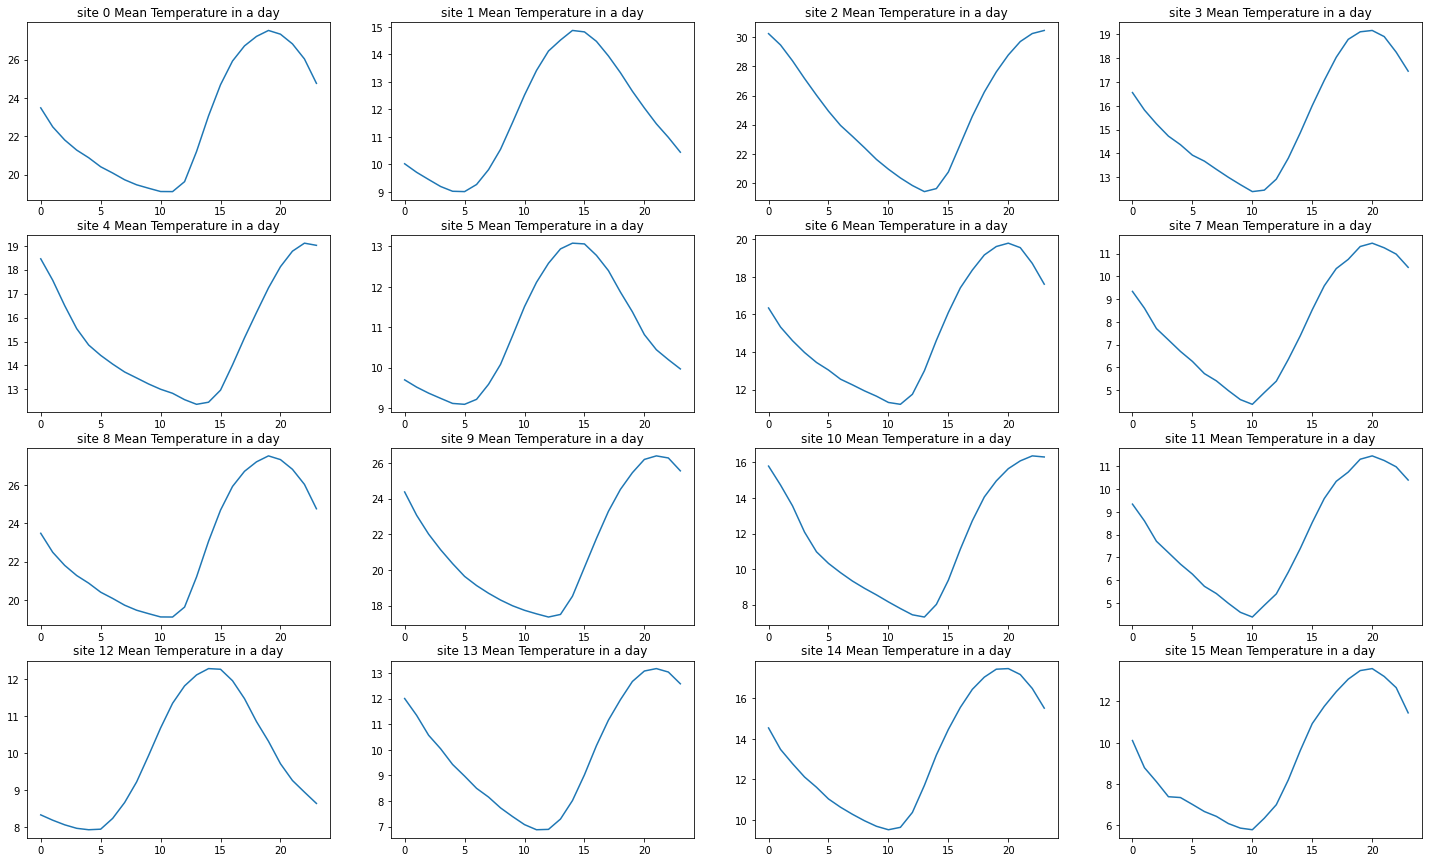

In [6]:
mean_site_temp(df_weather_train)
df_weather_train.drop('hour',axis=1,inplace=True)

- site 1,5,12 seems to show correct time intuatively.Lowest temperature at 5.
- site 0,6,8,13 seems to be in same time zone. Lowest temperatur at 11.
- site 2,4,9,10 seems to be in same time zone. Lowest temperatur at 13.
- site 3,7,11,14,15 seems to be in same time zone. Lowest temperatur at 10

In [7]:
timezone_0 = (0,[1,5,12])
timezone_1 = (5,[3,7,11,14,15])
timezone_2 = (6,[0,6,8,13])
timezone_3 = (8,[2,4,9,10])
def align_timestamp(timezone):
    '''This method is for timestamp alignment of the dataframe'''
    for site in timezone[1]:
        df_weather_train.loc[df_weather_train['site_id']==site,'timestamp']=(df_weather_train.loc[df_weather_train['site_id']\
                ==site,'timestamp']-pd.Timedelta(hours=timezone[0]))

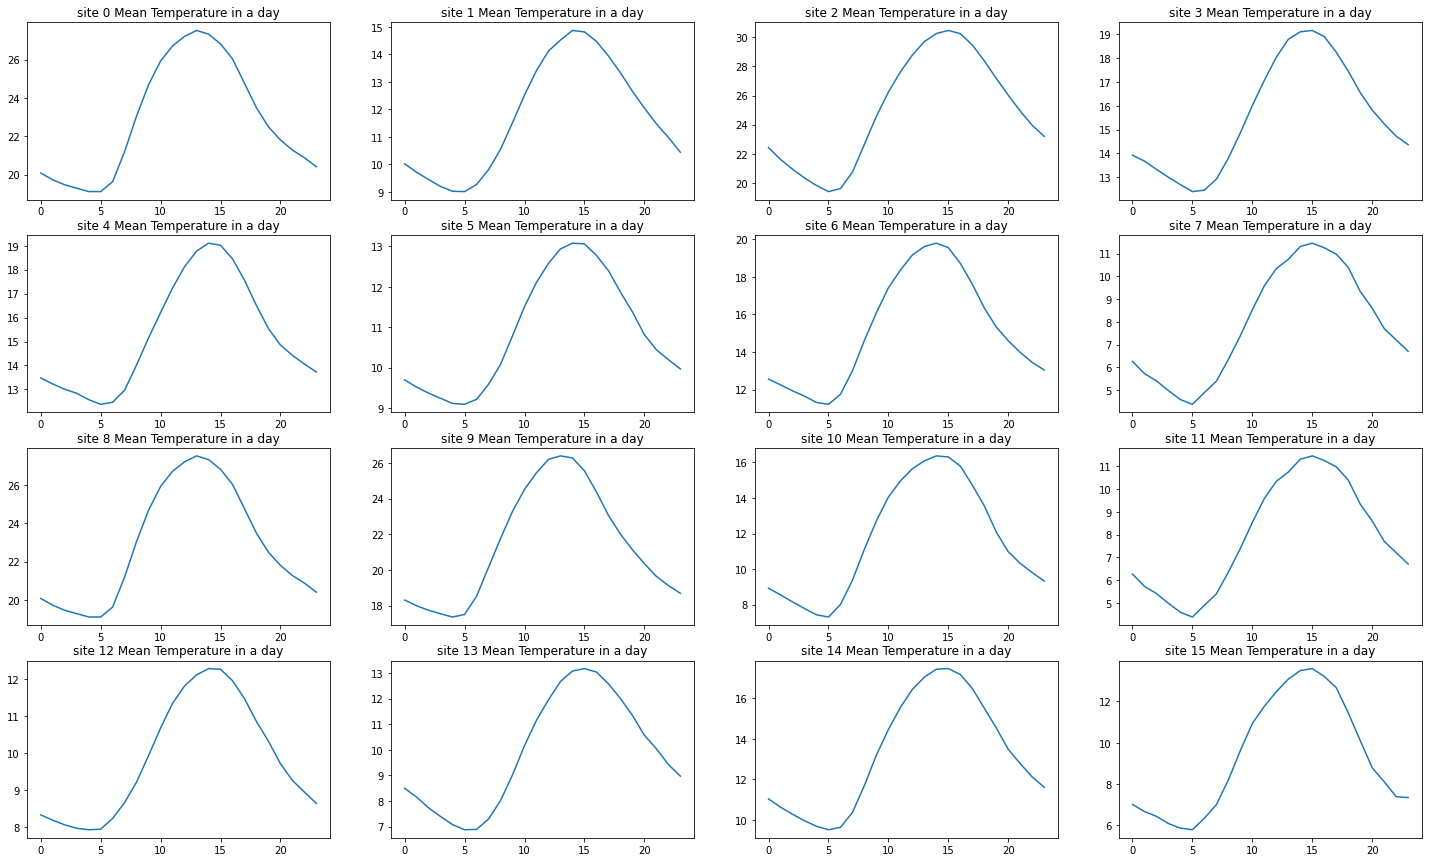

In [8]:
align_timestamp(timezone_1)
align_timestamp(timezone_2)
align_timestamp(timezone_3)
df_weather_train['hour'] = df_weather_train['timestamp'].dt.hour
mean_site_temp(df_weather_train)

- Site 1,5,12 temperatures are used as a refrence standard as they ituatively look correct.
- Lowest temperatures are picked to transform timezones across all other sites.
- All the sites now show similar mean hourly temperature.

<h3>3.1.2. Dealing with missing values of df_weather_train</h3>

- Missing values are filled with medians after grouping.

In [9]:
df_weather_train['day'] = df_weather_train['timestamp'].dt.day
df_weather_train['weekday'] = df_weather_train['timestamp'].dt.weekday
df_weather_train['month'] = df_weather_train['timestamp'].dt.month

In [10]:
df_weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
hour                      0
day                       0
weekday                   0
month                     0
dtype: int64

In [11]:
columnsWithNull = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure',\
                  'wind_direction','wind_speed']

for feature in columnsWithNull:
    #df_weather_train[feature].interpolate(method ='linear',limit=10000, limit_direction ='both',inplace=True)
    df_weather_train[feature] = df_weather_train[feature].fillna(df_weather_train.groupby(['site_id','month','day'])[feature]\
                                                                 .transform('median'))
    df_weather_train[feature] = df_weather_train[feature].fillna(df_weather_train.groupby(['site_id','month'])[feature]\
                                                                 .transform('median'))
    df_weather_train[feature] = df_weather_train[feature].fillna(df_weather_train[feature].median())

In [12]:
df_weather_train.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
day                   0
weekday               0
month                 0
dtype: int64

<h2>3.2. Read df_building_metadata</h2>

In [13]:
#Reading building_metadata.csv
df_building_metadata = describe_data('building_metadata.csv')

Shape of the data:  (1449, 6)
Columns datatype : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB
None
nans in the data: 
site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64
describe the data: 
           site_id  building_id    square_feet   year_built  floor_count
count  1449.000000  1449.000000    1449.000000   675.000000   355.000000
mean      6.952381   724.000000   92111.776398  1967.957037     3.740845
std       5.003432   418.434583  110769.950997   

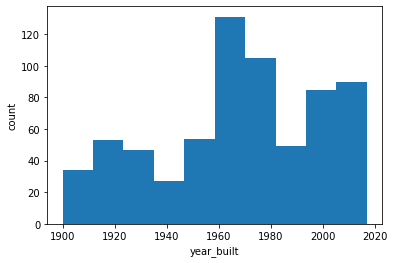

In [14]:
plt.hist(df_building_metadata['year_built']) 
plt.xlabel('year_built')
plt.ylabel('count')
plt.show()

<h3>3.2.1. Dealing with missing values of df_building_metadata</h3>

- Missing values are filled with mean after grouping.

In [15]:
columnsWithNull = ['year_built','floor_count']

for feature in columnsWithNull:
    #df_building_metadata[feature].interpolate(method ='linear',limit=10000, limit_direction ='both',inplace=True)
    df_building_metadata[feature] = df_building_metadata[feature].fillna(df_building_metadata.groupby\
                                                    (['site_id','primary_use'])[feature].transform('mean'))
    df_building_metadata[feature] = df_building_metadata[feature].fillna(df_building_metadata.groupby\
                                                    (['site_id'])[feature].transform('mean'))
    df_building_metadata[feature] = df_building_metadata[feature].fillna(df_building_metadata[feature].mean())

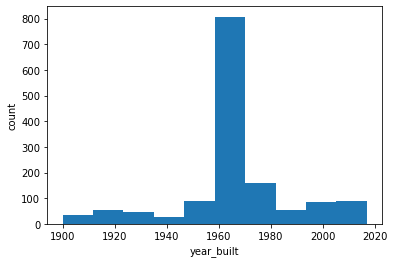

In [16]:
plt.hist(df_building_metadata['year_built']) 
plt.xlabel('year_built')
plt.ylabel('count')
plt.show()

- After imputing year_built the feature distribution is not affected as shown in histogram.

In [17]:
df_building_metadata.isna().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
year_built     0
floor_count    0
dtype: int64

<h2>3.3. Merge all three data frames</h2>

In [18]:
#reading train.csv
df_train = describe_data('train.csv')

Shape of the data:  (20216100, 4)
Columns datatype : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
None
nans in the data: 
building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64
describe the data: 
        building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   2.117121e+03
std    4.269133e+02  9.309921e-01   1.532356e+05
min    0.000000e+00  0.000000e+00   0.000000e+00
25%    3.930000e+02  0.000000e+00   1.830000e+01
50%    8.950000e+02  0.000000e+00   7.877500e+01
75%    1.179000e+03  1.000000e+00   2.679840e+02
max    1.448000e+03  3.000000e+00   2.190470e+07


In [19]:
df_building = df_building_metadata.merge(df_train,on='building_id',how='left')
df_building.dropna(inplace=True)
df_train = df_building.merge(df_weather_train, on=['site_id','timestamp'], how='left')
del df_building,df_weather_train

In [20]:
#Null values are dropped from the merged dataframe
#df_train = df_train.dropna()
df_train.isna().sum()

site_id                    0
building_id                0
primary_use                0
square_feet                0
year_built                 0
floor_count                0
meter                      0
timestamp                  0
meter_reading              0
air_temperature       102719
cloud_coverage        102719
dew_temperature       102719
precip_depth_1_hr     102719
sea_level_pressure    102719
wind_direction        102719
wind_speed            102719
hour                  102719
day                   102719
weekday               102719
month                 102719
dtype: int64

In [21]:
df_train.sort_values(by=['timestamp'],inplace=True)

In [22]:
columnsWithNull = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure',\
                  'wind_direction','wind_speed']

for feature in columnsWithNull:
    #df_train[feature].interpolate(method ='linear',limit=10000, limit_direction ='both',inplace=True)
    df_train[feature] = df_train[feature].fillna(df_train.groupby(['site_id','month','day'])[feature]\
                                                                 .transform('median'))
    df_train[feature] = df_train[feature].fillna(df_train.groupby(['site_id','month'])[feature]\
                                                                 .transform('median'))
    df_train[feature] = df_train[feature].fillna(df_train[feature].median())

df_train['hour'] = df_train['timestamp'].dt.hour
df_train['day'] = df_train['timestamp'].dt.day
df_train['weekday'] = df_train['timestamp'].dt.weekday
df_train['month'] = df_train['timestamp'].dt.month

In [23]:
#Size of the dataframe is reduced by casting into appropriate data types
red_dic = {'site_id':np.int8, 'building_id': np.int16, 'square_feet':np.int32,'meter':np.int8,'year_built':np.float16,\
           'floor_count':np.float16,'meter_reading':np.float32,'air_temperature':np.float16,'cloud_coverage':np.float16,\
           'dew_temperature':np.float16,'precip_depth_1_hr':np.float16,'sea_level_pressure':np.float16,\
           'wind_direction':np.float16,'wind_speed':np.float16,'hour':np.uint8,'day':np.uint8,'weekday':np.uint8,\
           'month':np.uint8}
df_train = df_train.astype(red_dic)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             int8          
 1   building_id         int16         
 2   primary_use         object        
 3   square_feet         int32         
 4   year_built          float16       
 5   floor_count         float16       
 6   meter               int8          
 7   timestamp           datetime64[ns]
 8   meter_reading       float32       
 9   air_temperature     float16       
 10  cloud_coverage      float16       
 11  dew_temperature     float16       
 12  precip_depth_1_hr   float16       
 13  sea_level_pressure  float16       
 14  wind_direction      float16       
 15  wind_speed          float16       
 16  hour                uint8         
 17  day                 uint8         
 18  weekday             uint8         
 19  month               uint8         
dtype

<h2>3.4. Cleaning outliers</h2>

In [24]:
# converting site 0 meter_readings to kwh
in_size = df_train.shape[0]
df_train.loc[df_train.site_id == 0, 'meter_reading'] = df_train.loc[df_train.site_id == 0, 'meter_reading']/3.4121416

In [25]:
for qt in range(90,100):
    print('meter_reading at ',qt,' percentile is ',np.percentile(df_train["meter_reading"],qt))
print('meter_reading at ',99.9,' percentile is ',np.percentile(df_train["meter_reading"],99.9))

meter_reading at  90  percentile is  754.6082153320312
meter_reading at  91  percentile is  842.0171166992186
meter_reading at  92  percentile is  940.1690673828125
meter_reading at  93  percentile is  1058.5899658203125
meter_reading at  94  percentile is  1227.800048828125
meter_reading at  95  percentile is  1455.0799560546875
meter_reading at  96  percentile is  1776.4300537109375
meter_reading at  97  percentile is  2280.2903393554807
meter_reading at  98  percentile is  3156.25
meter_reading at  99  percentile is  5178.240234375
meter_reading at  99.9  percentile is  38671.8984375


In [26]:
#drop outliers greater than 99.9 percentile
df_train = df_train.drop(df_train.loc[df_train.meter_reading >= np.percentile(df_train["meter_reading"],99.9)].index)
print('Number of data points : ', df_train.shape[0])
print('Number of features : ', df_train.shape[1])
print('Features : ', df_train.columns.values)

Number of data points :  20195880
Number of features :  20
Features :  ['site_id' 'building_id' 'primary_use' 'square_feet' 'year_built'
 'floor_count' 'meter' 'timestamp' 'meter_reading' 'air_temperature'
 'cloud_coverage' 'dew_temperature' 'precip_depth_1_hr'
 'sea_level_pressure' 'wind_direction' 'wind_speed' 'hour' 'day' 'weekday'
 'month']


In [27]:
print('Percentage of Train data left after removing meter_reading outliers: ', round((df_train.shape[0]/in_size),4)*100)

Percentage of Train data left after removing meter_reading outliers:  99.9


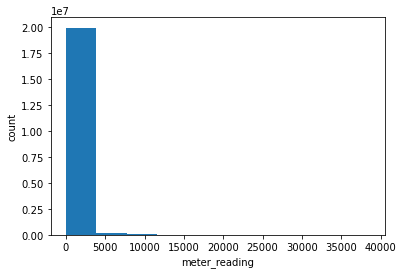

In [28]:
plt.hist(df_train['meter_reading'])
plt.xlabel('meter_reading')
plt.ylabel('count')
plt.show()

- meter_reading still looks skwed. It will be log transformed while dealing with all other skewd features. 

In [29]:
df_train['year_hour'] = ((df_train['timestamp'] - df_train.iloc[0].timestamp)/timedelta(hours=1))

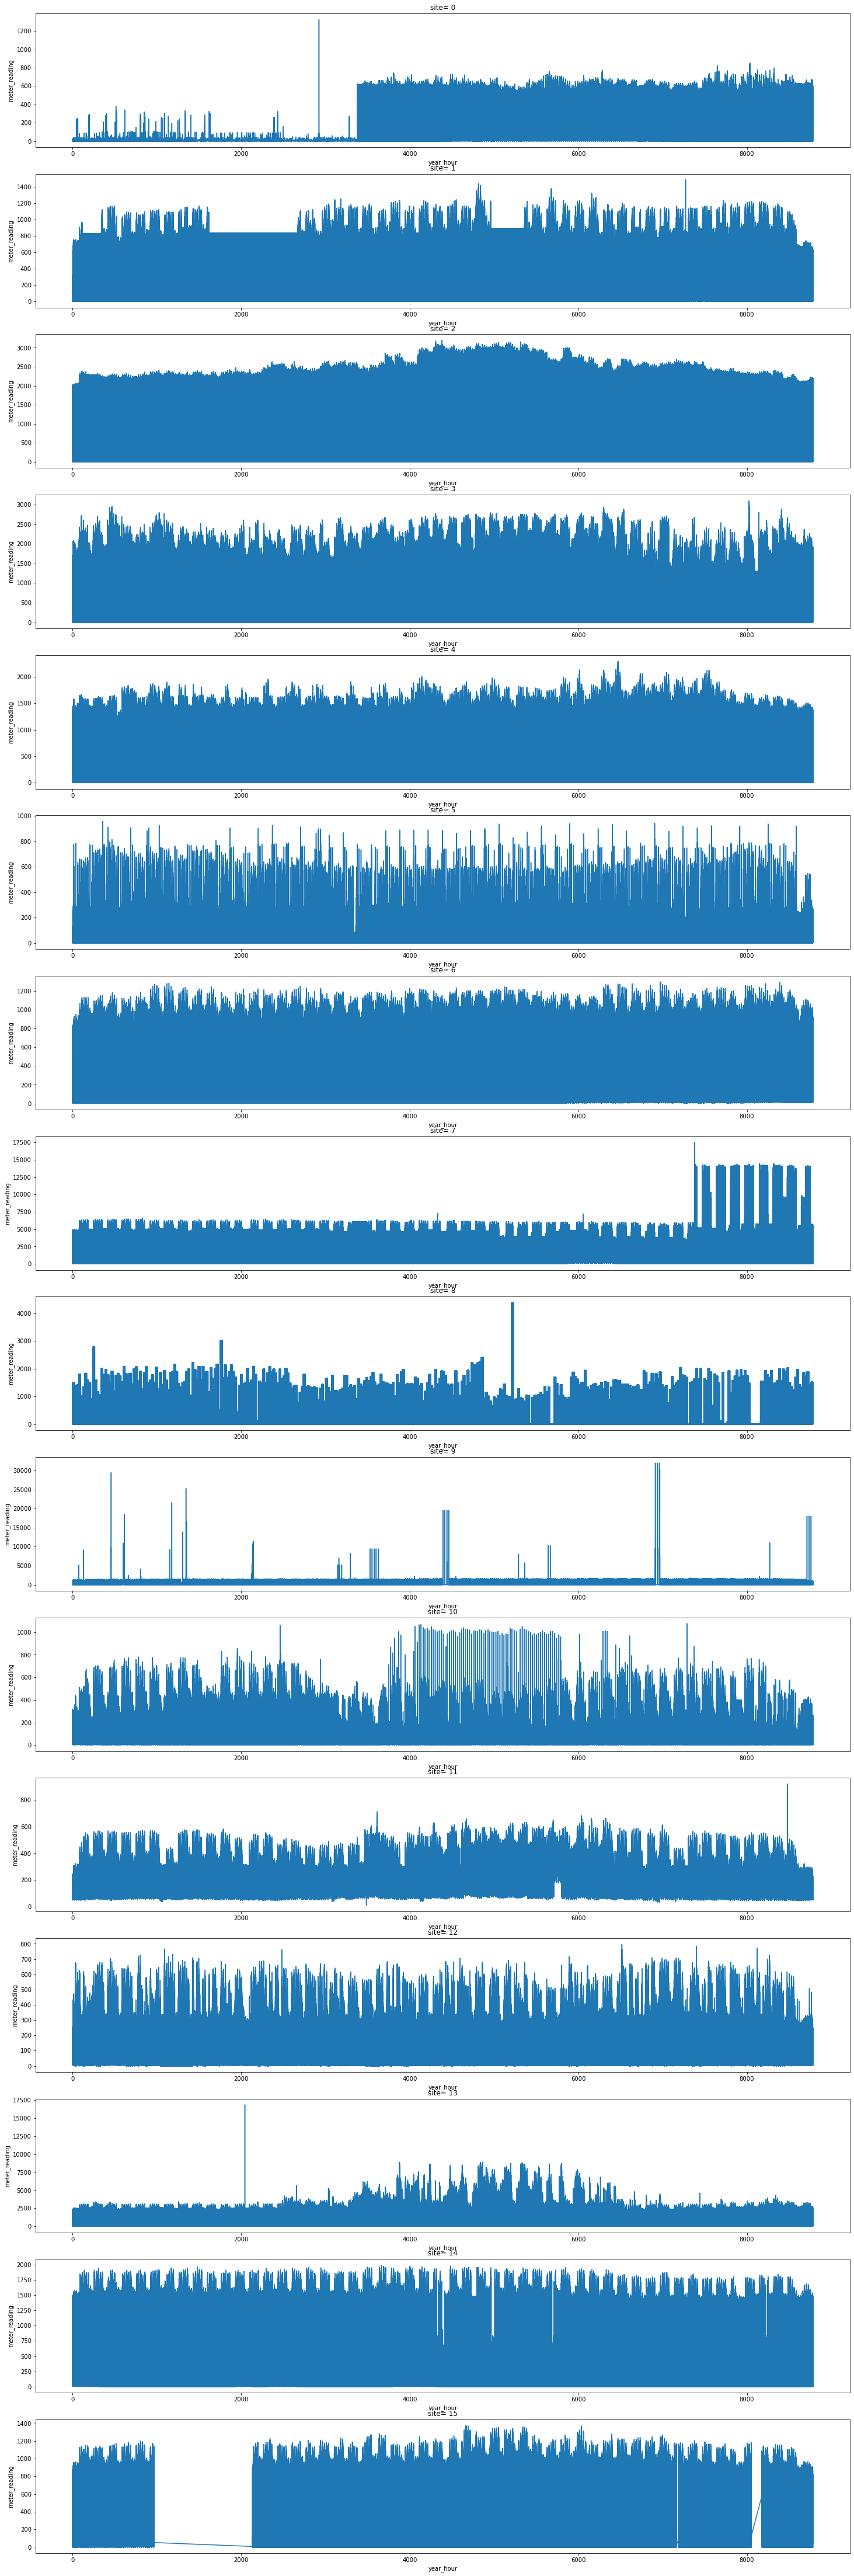

In [30]:
plt.figure(figsize=(25, 80))
for site in range(0,16):
    ax = plt.subplot(16, 1, site+1)
    plt.plot(df_train.loc[(df_train['site_id']==site)&(df_train['meter']==0)]['year_hour'],df_train.loc[(df_train['site_id']\
                                                                ==site)&(df_train['meter']==0)]['meter_reading'])
    plt.xlabel('year_hour')
    plt.ylabel('meter_reading')
    plt.title('site= '+str(site))

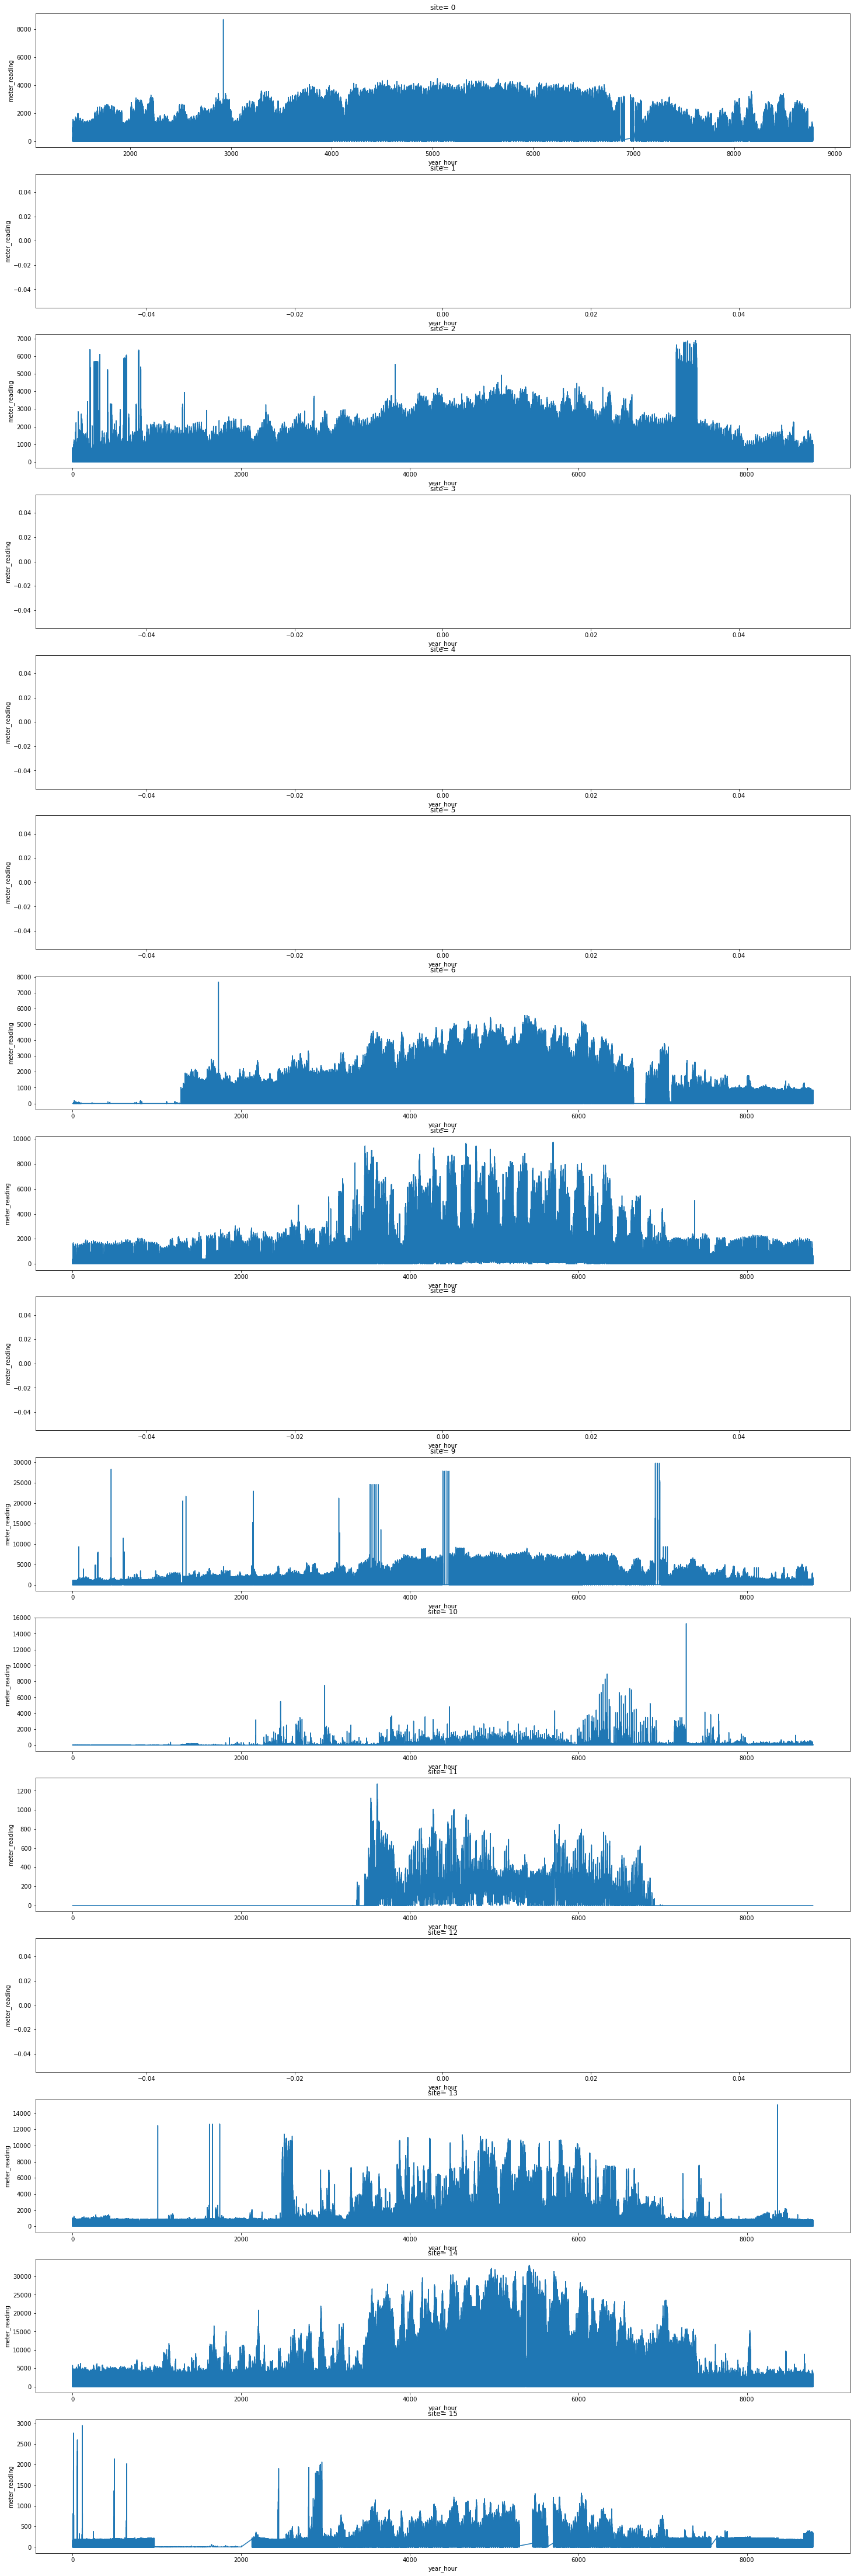

In [31]:
plt.figure(figsize=(25, 80))
for site in range(0,16):
    ax = plt.subplot(16, 1, site + 1)
    plt.plot(df_train.loc[(df_train['site_id']==site)&(df_train['meter']==1)]['year_hour'],df_train.loc[(df_train['site_id']\
                                                                ==site)&(df_train['meter']==1)]['meter_reading'])
    plt.xlabel('year_hour')
    plt.ylabel('meter_reading')
    plt.title('site= '+str(site))

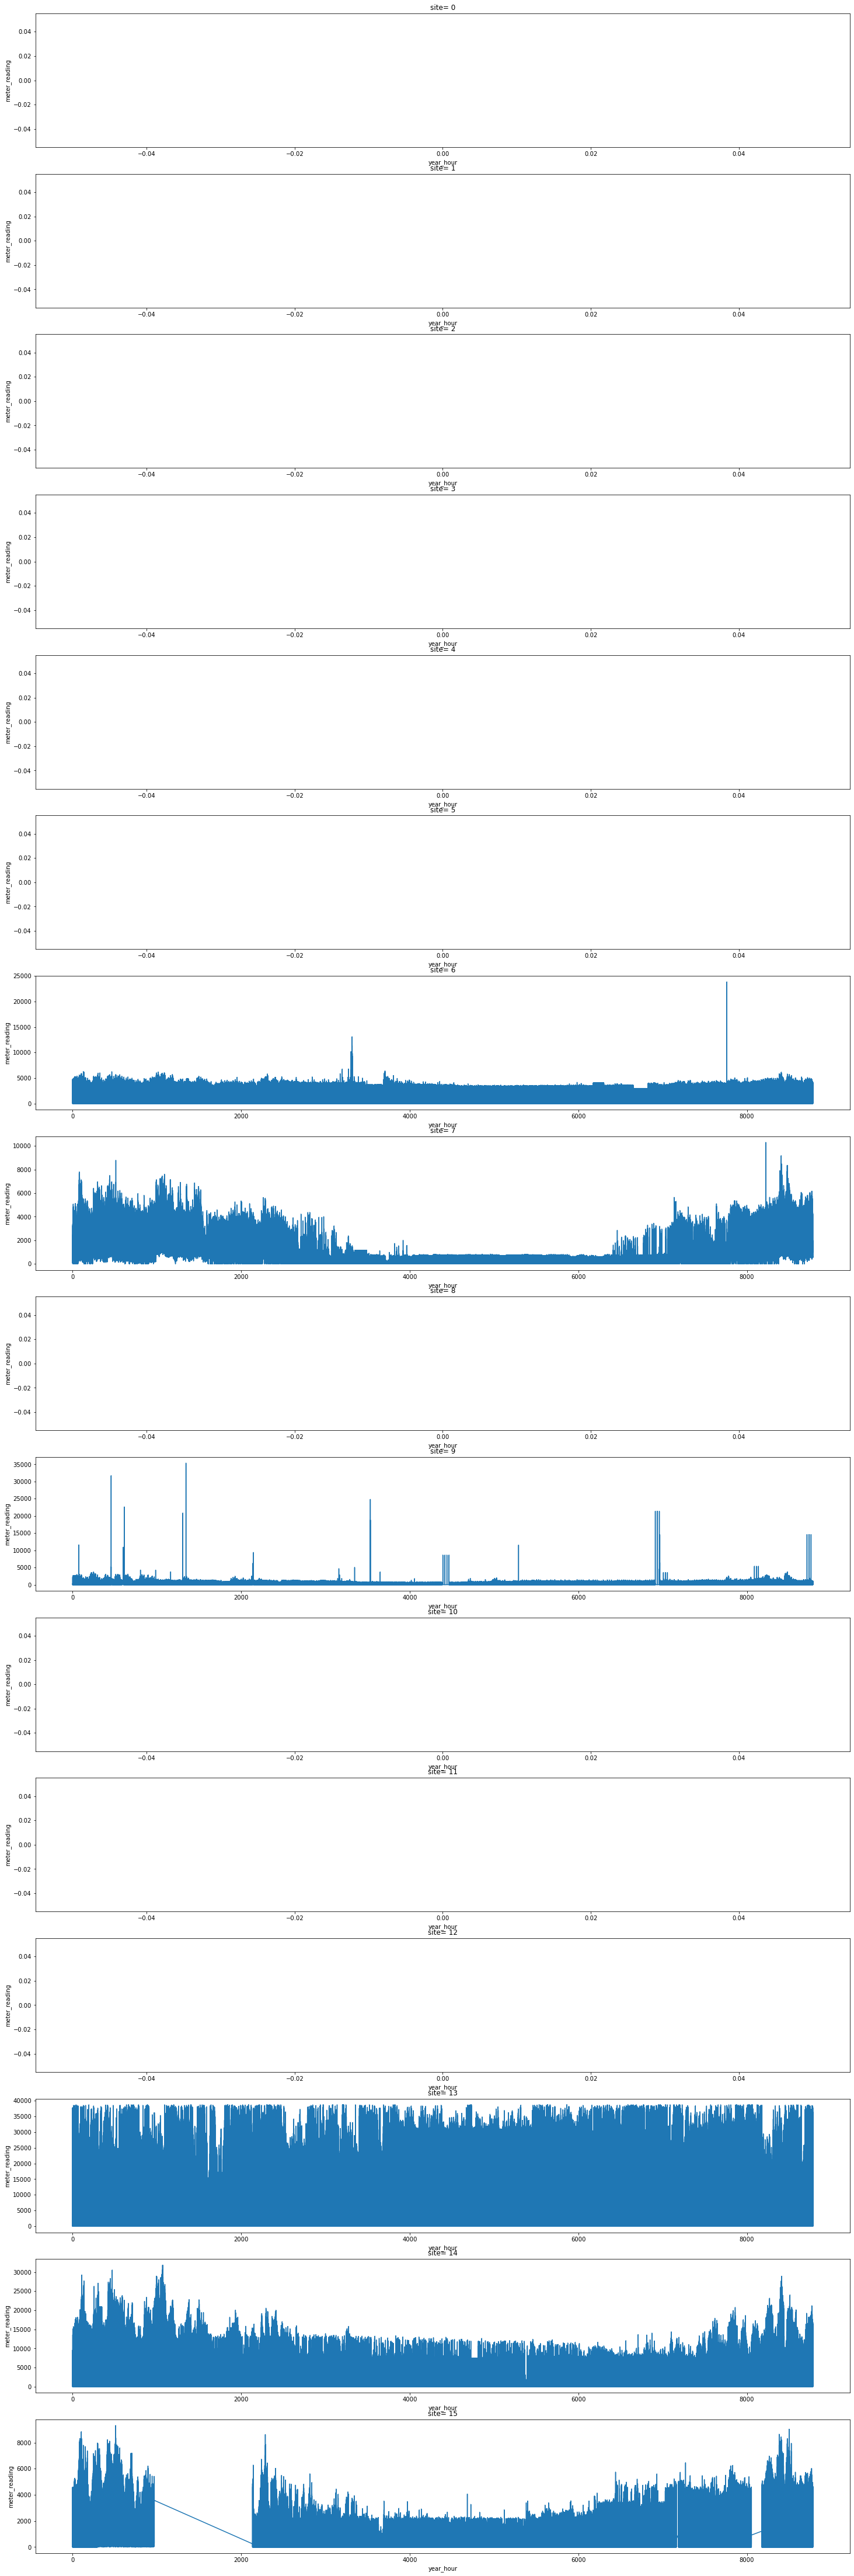

In [32]:
plt.figure(figsize=(25, 80))
for site in range(0,16):
    ax = plt.subplot(16, 1, site + 1)
    plt.plot(df_train.loc[(df_train['site_id']==site)&(df_train['meter']==2)]['year_hour'],df_train.loc\
                 [(df_train['site_id']==site)&(df_train['meter']==2)]['meter_reading'])
    plt.title('site= '+str(site))
    plt.xlabel('year_hour')
    plt.ylabel('meter_reading')

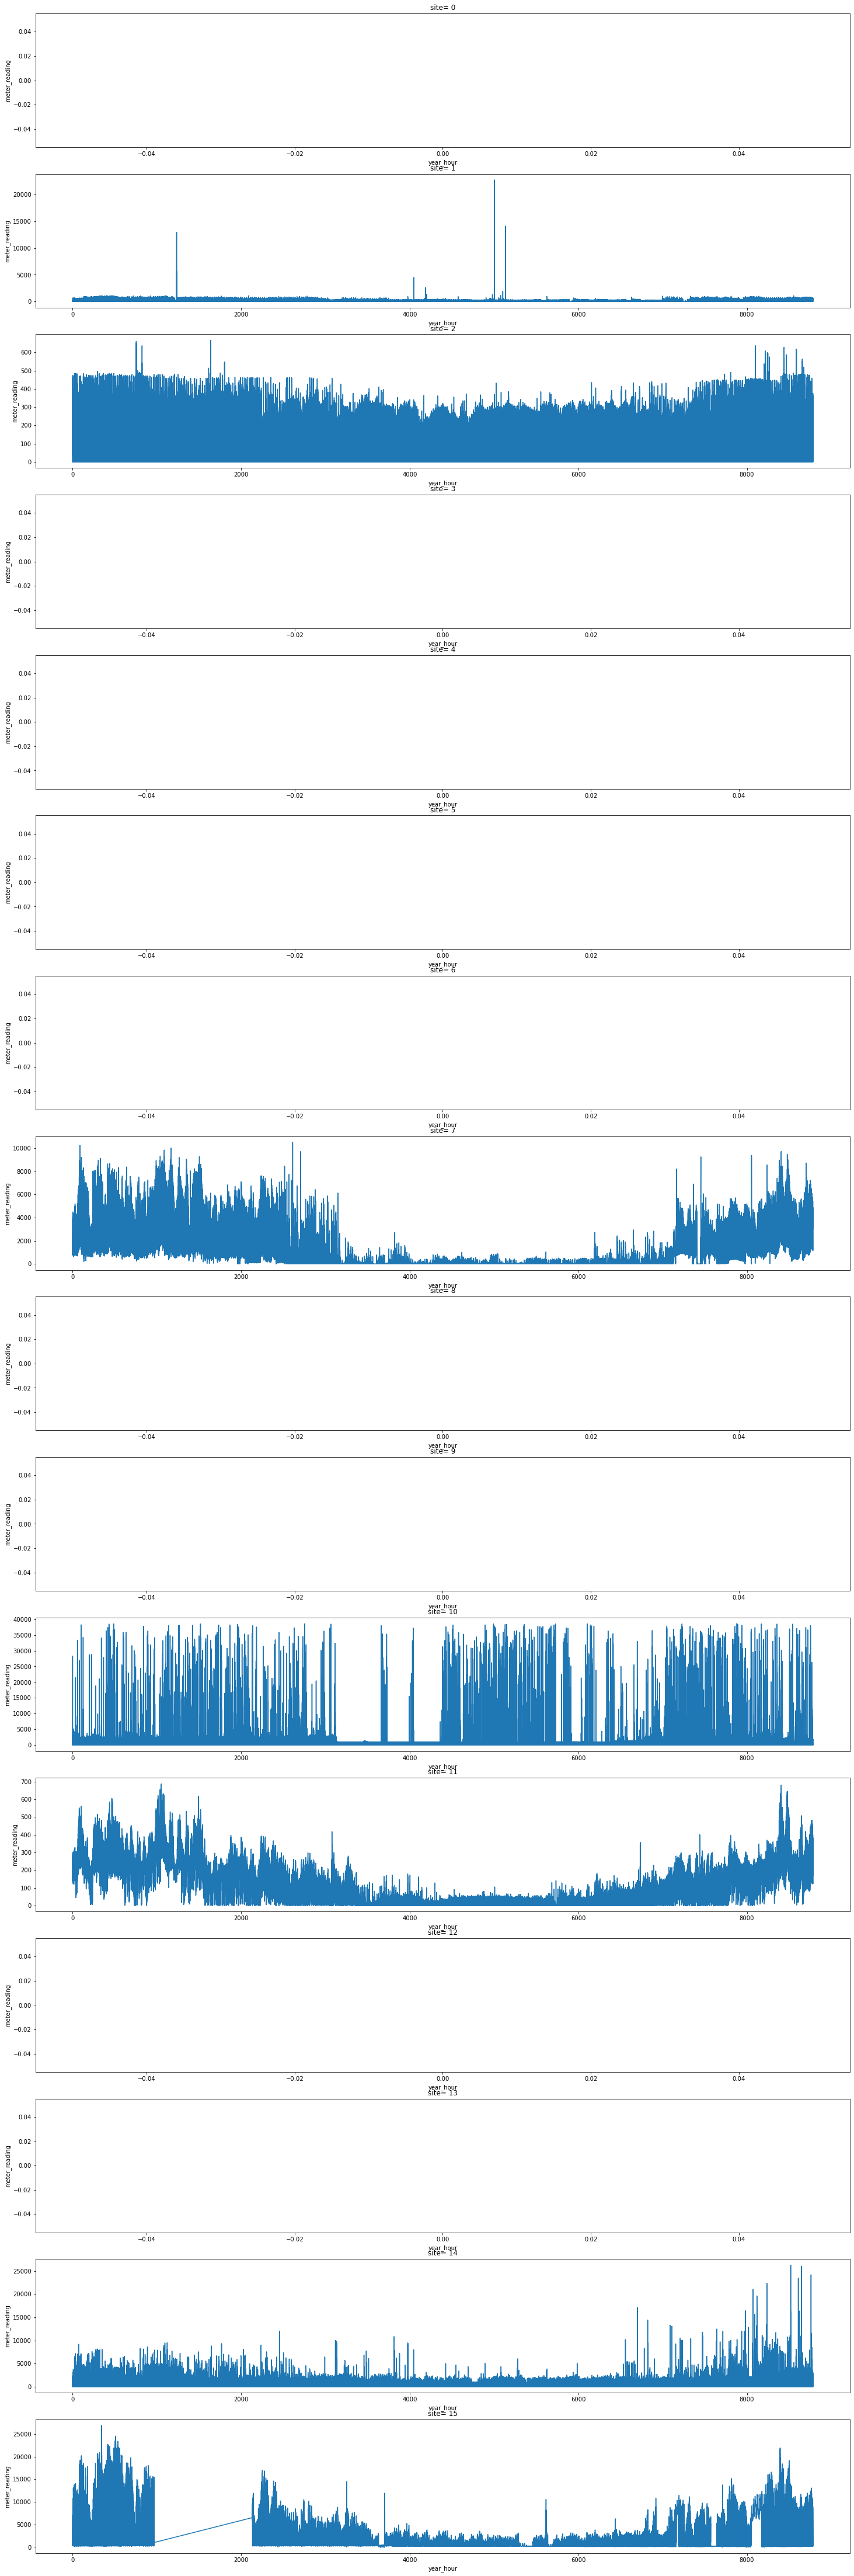

In [33]:
plt.figure(figsize=(25, 80))
for site in range(0,16):
    ax = plt.subplot(16, 1, site + 1)
    plt.plot(df_train.loc[(df_train['site_id']==site)&(df_train['meter']==3)]['year_hour'],df_train.loc[(df_train['site_id']\
                                                                ==site)&(df_train['meter']==3)]['meter_reading'])
    plt.xlabel('year_hour')
    plt.ylabel('meter_reading')
    plt.title('site= '+str(site))

In [34]:
#electricity readings should have less variance in the data. site 0 of electricity reading shows anomily readings till 3384 hours
df_train.drop(df_train.loc[(df_train['site_id']==0)&(df_train['meter']==0)&(df_train['year_hour']<=3384)].index,inplace=True)

In [35]:
def make_is_bad_zero(Xy_subset, min_interval=48, summer_start=3000, summer_end=7500):
    """Helper routine for 'find_bad_zeros'.
    
    This operates upon a single dataframe produced by 'groupby'. We expect an 
    additional column 'meter' which is a duplicate of 'meter' because groupby 
    eliminates the original one."""
    meter = Xy_subset.meter.iloc[0]
    is_zero = Xy_subset.meter_reading == 0
    if meter == 0:
        # Electrical meters should never be zero. Keep all zero-readings in this table so that
        # they will all be dropped in the train set.
        return is_zero
    transitions = (is_zero != is_zero.shift(1))
    all_sequence_ids = transitions.cumsum()
    ids = all_sequence_ids[is_zero].rename("ids")
    if meter in [2, 3]:
        # It's normal for steam and hotwater to be turned off during the summer
        keep = set(ids[(Xy_subset.year_hour < summer_start) |
                       (Xy_subset.year_hour > summer_end)].unique())
        is_bad = ids.isin(keep) & (ids.map(ids.value_counts()) >= min_interval)
    elif meter == 1:
        time_ids = ids.to_frame().join(Xy_subset.year_hour).set_index("year_hour").ids
        is_bad = ids.map(ids.value_counts()) >= min_interval

        # Cold water may be turned off during the winter
        jan_id = time_ids.get(0, False)
        dec_id = time_ids.get(8283, False)
        if (jan_id and dec_id and jan_id == time_ids.get(500, False) and
                dec_id == time_ids.get(8783, False)):
            is_bad = is_bad & (~(ids.isin(set([jan_id, dec_id]))))
    else:
        raise Exception(f"Unexpected meter type: {meter}")

    result = is_zero.copy()
    result.update(is_bad)
    return result

In [36]:
zero_index = []
for grp,items in tqdm(df_train.groupby(["building_id", "meter"])):
    zero_idx = make_is_bad_zero(items)
    idx = zero_idx[zero_idx].index
    zero_index.extend(idx.tolist())

100%|█████████████████████████████████████████████████████████████████████████████| 2380/2380 [00:15<00:00, 152.71it/s]


In [37]:
df_train.drop(zero_index,inplace = True )
df_train.drop(['year_hour'],axis='columns', inplace = True )

<h2>3.5. Interpreting Numerical features</h2>

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19211998 entries, 13407074 to 20216099
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             int8          
 1   building_id         int16         
 2   primary_use         object        
 3   square_feet         int32         
 4   year_built          float16       
 5   floor_count         float16       
 6   meter               int8          
 7   timestamp           datetime64[ns]
 8   meter_reading       float32       
 9   air_temperature     float16       
 10  cloud_coverage      float16       
 11  dew_temperature     float16       
 12  precip_depth_1_hr   float16       
 13  sea_level_pressure  float16       
 14  wind_direction      float16       
 15  wind_speed          float16       
 16  hour                uint8         
 17  day                 uint8         
 18  weekday             uint8         
 19  month               uint8        

- All the numerical features are plotted to see there distribution

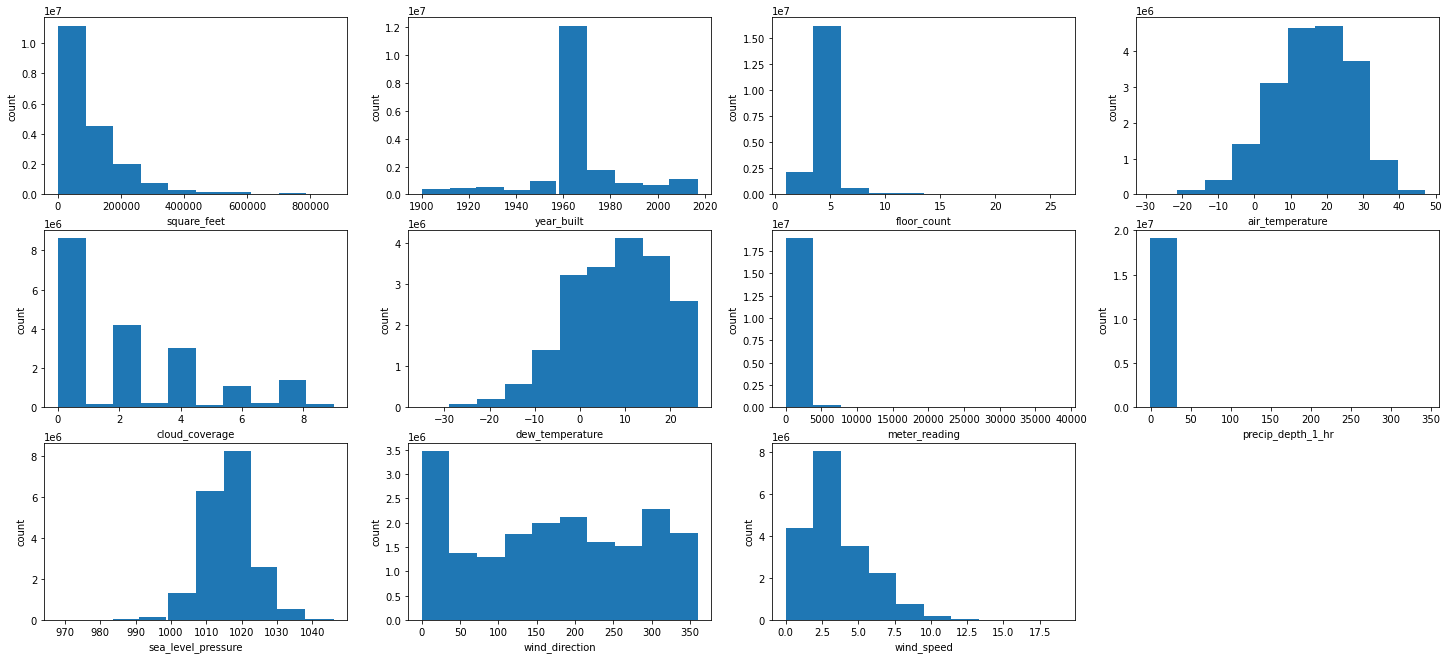

In [39]:
col_names = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature','meter_reading',\
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
plt.figure(figsize=(25, 15))
i=0
for col in col_names:
    ax = plt.subplot(4, 4, i + 1)
    plt.hist(df_train[col])
    plt.xlabel(col)
    plt.ylabel('count')
    i=i+1

- Skewed features are log transformed to improve accuracy of the regression probelm

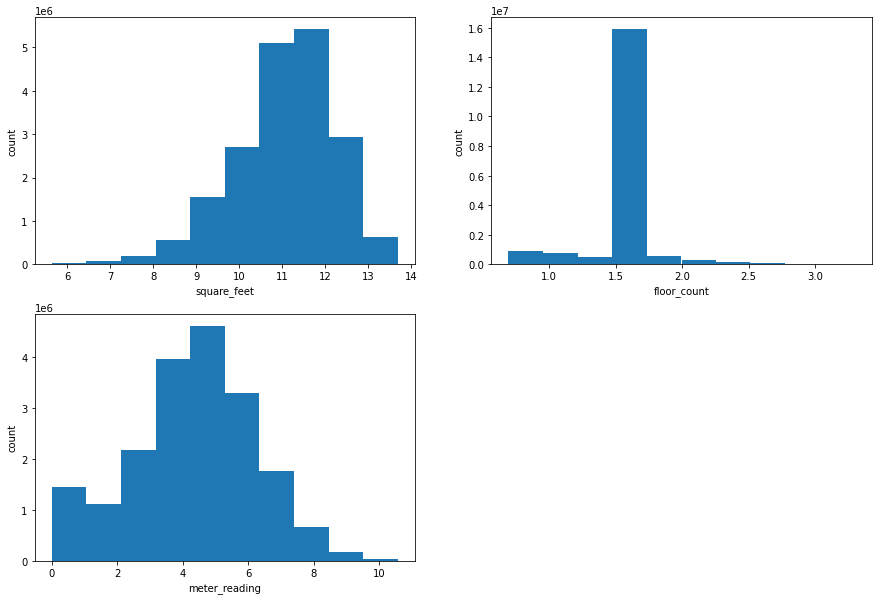

In [40]:
log_col_names = ['square_feet','floor_count','meter_reading']
df_train[log_col_names] = np.log(df_train[log_col_names] + 1)

plt.figure(figsize=(15, 10))
i=0
for col in log_col_names:
    ax = plt.subplot(2, 2, i + 1)
    plt.hist(df_train[col])
    plt.xlabel(col)
    plt.ylabel('count')
    i=i+1

<h2>3.6. Feature engineering</h2>

In [41]:
df_train['sin_wind_direction'] = np.sin(2*np.pi*(df_train['wind_direction']/max(df_train['wind_direction'])))
df_train['cos_wind_direction'] = np.cos(2*np.pi*(df_train['wind_direction']/max(df_train['wind_direction'])))
df_train['sin_hour'] = np.sin(2*np.pi*(df_train['hour']/max(df_train['hour'])))
df_train['cos_hour'] = np.cos(2*np.pi*(df_train['hour']/max(df_train['hour'])))
df_train['sin_day'] = np.sin(2*np.pi*(df_train['day']/max(df_train['day'])))
df_train['cos_day'] = np.cos(2*np.pi*(df_train['day']/max(df_train['day'])))
df_train['sin_month'] = np.sin(2*np.pi*(df_train['month']/max(df_train['month'])))
df_train['cos_month'] = np.cos(2*np.pi*(df_train['month']/max(df_train['month'])))

df_train['holidays'] = 0
df_train.loc[(df_train['weekday'] == 5) | (df_train['weekday'] == 6) , 'holidays'] = 1

#removing some columns which doesnt look useful
df_train.drop(['hour','day','month','wind_direction'],axis='columns',inplace=True)

In [42]:
#Size of the dataframe is reduced by casting into appropriate data types
red_dic = {'sin_hour':np.float16, 'cos_hour': np.float16, 'sin_day':np.float16,'cos_day':np.float16,'sin_month':np.float16,\
           'cos_month':np.float16,'holidays':np.int8,'square_feet':np.float16}
df_train = df_train.astype(red_dic)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19211998 entries, 13407074 to 20216099
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             int8          
 1   building_id         int16         
 2   primary_use         object        
 3   square_feet         float16       
 4   year_built          float16       
 5   floor_count         float16       
 6   meter               int8          
 7   timestamp           datetime64[ns]
 8   meter_reading       float32       
 9   air_temperature     float16       
 10  cloud_coverage      float16       
 11  dew_temperature     float16       
 12  precip_depth_1_hr   float16       
 13  sea_level_pressure  float16       
 14  wind_speed          float16       
 15  weekday             uint8         
 16  sin_wind_direction  float16       
 17  cos_wind_direction  float16       
 18  sin_hour            float16       
 19  cos_hour            float16      

- Time series features are best utilized when sin and cos normalized
- Also holiday feature is added as it does seem like effecting meter reading

In [43]:
#considering only numerical features to plot correlation heatmap
num_features = list(df_train.columns.values)
num_features.remove('primary_use')
num_features.remove('site_id')
num_features.remove('building_id')
num_features.remove('meter')
#no timestamp and meter_reading
num_features.remove('timestamp')
num_features.remove('meter_reading')

In [44]:
df_train_num_corr = df_train[num_features].corr()

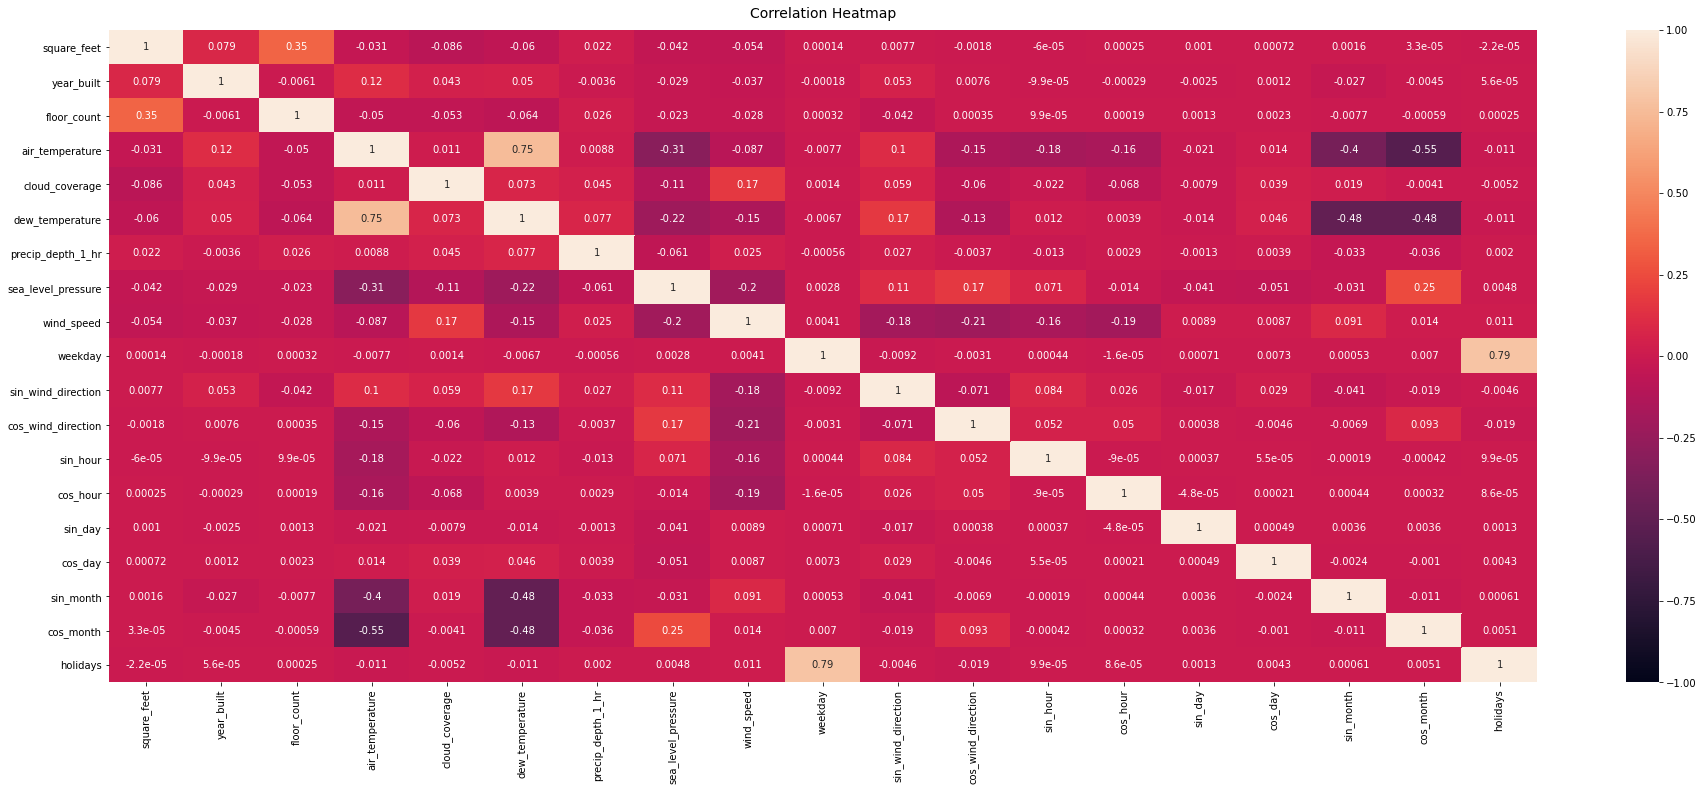

In [45]:
plt.figure(figsize=(32, 12))
htmap = sns.heatmap(df_train_num_corr, vmin=-1, vmax=1, annot=True)
htmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

- From correlation matrix, Weekday and holidays feature are similar so we can remove one of them.
- Also air_temperature and dew_temperature are closely related.

In [46]:
df_train.drop(['weekday','dew_temperature','timestamp'],axis='columns',inplace=True)

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19211998 entries, 13407074 to 20216099
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   site_id             int8   
 1   building_id         int16  
 2   primary_use         object 
 3   square_feet         float16
 4   year_built          float16
 5   floor_count         float16
 6   meter               int8   
 7   meter_reading       float32
 8   air_temperature     float16
 9   cloud_coverage      float16
 10  precip_depth_1_hr   float16
 11  sea_level_pressure  float16
 12  wind_speed          float16
 13  sin_wind_direction  float16
 14  cos_wind_direction  float16
 15  sin_hour            float16
 16  cos_hour            float16
 17  sin_day             float16
 18  cos_day             float16
 19  sin_month           float16
 20  cos_month           float16
 21  holidays            int8   
dtypes: float16(16), float32(1), int16(1), int8(3), object(1)
memory usage: 1.0+ GB


<h2>3.5. Encoding categorical features</h2>

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19211998 entries, 13407074 to 20216099
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   site_id             int8   
 1   building_id         int16  
 2   primary_use         object 
 3   square_feet         float16
 4   year_built          float16
 5   floor_count         float16
 6   meter               int8   
 7   meter_reading       float32
 8   air_temperature     float16
 9   cloud_coverage      float16
 10  precip_depth_1_hr   float16
 11  sea_level_pressure  float16
 12  wind_speed          float16
 13  sin_wind_direction  float16
 14  cos_wind_direction  float16
 15  sin_hour            float16
 16  cos_hour            float16
 17  sin_day             float16
 18  cos_day             float16
 19  sin_month           float16
 20  cos_month           float16
 21  holidays            int8   
dtypes: float16(16), float32(1), int16(1), int8(3), object(1)
memory usage: 1.0+ GB


In [49]:
def target_encode(df,col):
    target_en = df.groupby([col])['meter_reading'].mean()
    for cat,val in target_en.items():
        df.loc[df[col]==cat,col]=val
    return df,target_en

In [50]:
df_train,target_en_primary_use = target_encode(df_train,'primary_use')
df_train,target_en_site_id = target_encode(df_train,'site_id')
df_train,target_en_building_id = target_encode(df_train,'building_id')

In [51]:
red_dic = {'primary_use':np.float16, 'site_id':np.float16, 'building_id':np.float16}
df_train = df_train.astype(red_dic)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19211998 entries, 13407074 to 20216099
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   site_id             float16
 1   building_id         float16
 2   primary_use         float16
 3   square_feet         float16
 4   year_built          float16
 5   floor_count         float16
 6   meter               int8   
 7   meter_reading       float32
 8   air_temperature     float16
 9   cloud_coverage      float16
 10  precip_depth_1_hr   float16
 11  sea_level_pressure  float16
 12  wind_speed          float16
 13  sin_wind_direction  float16
 14  cos_wind_direction  float16
 15  sin_hour            float16
 16  cos_hour            float16
 17  sin_day             float16
 18  cos_day             float16
 19  sin_month           float16
 20  cos_month           float16
 21  holidays            int8   
dtypes: float16(19), float32(1), int8(2)
memory usage: 952.7 MB


<h2>3.8. Test train split</h2>

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19211998 entries, 13407074 to 20216099
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   site_id             float16
 1   building_id         float16
 2   primary_use         float16
 3   square_feet         float16
 4   year_built          float16
 5   floor_count         float16
 6   meter               int8   
 7   meter_reading       float32
 8   air_temperature     float16
 9   cloud_coverage      float16
 10  precip_depth_1_hr   float16
 11  sea_level_pressure  float16
 12  wind_speed          float16
 13  sin_wind_direction  float16
 14  cos_wind_direction  float16
 15  sin_hour            float16
 16  cos_hour            float16
 17  sin_day             float16
 18  cos_day             float16
 19  sin_month           float16
 20  cos_month           float16
 21  holidays            int8   
dtypes: float16(19), float32(1), int8(2)
memory usage: 952.7 MB


In [53]:
x_cols = list(df_train.columns.values)
x_cols.remove('meter_reading')

In [54]:
#80:20 random split is performed
X_train, X_test, y_train, y_test = train_test_split(df_train[x_cols], df_train['meter_reading'],test_size=0.20, random_state=42)
del df_train

In [55]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 15369598
Number of data points in test data: 3842400


<h1>4. Machine Learning Models</h1>

<h3>4.1. Random Model</h3>

In [56]:
def return_mean(y_true):
    '''Fills all the rows with the respective mean value'''
    mean = y_true.mean()
    y = []
    for i in range(0,len(y_true)):
        y.append(mean)
    return y

In [57]:
rnd_train_pred = return_mean(y_train)
rnd_test_pred = return_mean(y_test)

rsme_train_random = mean_squared_error(y_train, rnd_train_pred, squared=False)
mae_train_random = mean_absolute_error(y_train, rnd_train_pred)
r2_train_random = r2_score(y_train,rnd_train_pred)
print('RMSE on trian data using random model is ', rsme_train_random)
print('MAE on trian data using random model is ', mae_train_random)
print('R2 on train data using random model is ', r2_train_random)

print(100*'*')
rsme_test_random = mean_squared_error(y_test, rnd_test_pred, squared=False)
mae_test_random = mean_absolute_error(y_test, rnd_test_pred)
r2_test_random = r2_score(y_test,rnd_test_pred)
print('RMSE on test data using random model is ', rsme_test_random)
print('MAE on test data using random model is ', mae_test_random)
print('R2 on test data using random model is ', r2_test_random)

RMSE on trian data using random model is  1.946624189112734
MAE on trian data using random model is  1.5254682234409036
R2 on train data using random model is  -0.00023134054356899192
****************************************************************************************************
RMSE on test data using random model is  1.946696502332369
MAE on test data using random model is  1.5239419643260548
R2 on test data using random model is  -8.562321487382007e-07


<h3>4.2. Random forest</h3>

- 4 random forrest models are trained on each of the four meters.

In [58]:
def get_meter_index(df):
    index_0 = df.loc[df['meter']==0].index
    index_1 = df.loc[df['meter']==1].index
    index_2 = df.loc[df['meter']==2].index
    index_3 = df.loc[df['meter']==3].index
    idx_lst = [index_0,index_1,index_2,index_3]
    return idx_lst

In [59]:
idx_lst_train = get_meter_index(X_train)

In [60]:
t_0 = timeit.default_timer()
rndf_models= []
for idx in tqdm(idx_lst_train):
    model = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=120, \
                              n_jobs=-1,random_state = 42)
    model.fit(X_train.loc[idx].drop('meter',axis='columns'), y_train.loc[idx])
    rndf_models.append(model)
t_1 = timeit.default_timer()
elapsed_time = round((t_1 - t_0), 3)
print(f"Elapsed time: {elapsed_time/60} min")

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [19:11<00:00, 287.90s/it]

Elapsed time: 19.19475 min


In [61]:
idx_lst_test = get_meter_index(X_test)

In [62]:
t_0 = timeit.default_timer()
rndf_train_predictions=[]
rndf_test_predictions=[]
y_train_updated=[]
y_test_updated=[]
for idx in tqdm(range(0,4)):
    y_pred = rndf_models[idx].predict(X_train.loc[idx_lst_train[idx]].drop('meter',axis='columns'))
    rndf_train_predictions.extend([round(value) for value in y_pred])
    y_train_updated.extend(y_train.loc[idx_lst_train[idx]])
    
    y_pred_ = rndf_models[idx].predict(X_test.loc[idx_lst_test[idx]].drop('meter',axis='columns'))
    rndf_test_predictions.extend([round(value) for value in y_pred_])
    y_test_updated.extend(y_test.loc[idx_lst_test[idx]])
t_1 = timeit.default_timer()


elapsed_time = round((t_1 - t_0), 3)
print(f"Elapsed time: {elapsed_time/60} min")

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:30<00:00, 127.70s/it]

Elapsed time: 8.5137 min


In [63]:
rsme_train_rndf = mean_squared_error(y_train_updated,rndf_train_predictions, squared=False)
mae_train_rndf = mean_absolute_error(y_train_updated,rndf_train_predictions)
r2_train_rndf = r2_score(y_train_updated,rndf_train_predictions)
print('RMSE on train data using random forest model is ', rsme_train_rndf)
print('MAE on train data using random forest model is ', mae_train_rndf)
print('R2 on train data using random forest model is ', r2_train_rndf)

print(100*'*')
rsme_test_rndf = mean_squared_error(y_test_updated,rndf_test_predictions, squared=False)
mae_test_rndf = mean_absolute_error(y_test_updated,rndf_test_predictions)
r2_test_rndf = r2_score(y_test_updated,rndf_test_predictions)
print('RMSE on test data using random forest model is ', rsme_test_rndf)
print('MAE on test data using random forest model is ', mae_test_rndf)
print('R2 on test data using random forest model is ', r2_test_rndf)

RMSE on train data using random forest model is  0.4787073295185314
MAE on train data using random forest model is  0.3231885585389786
R2 on train data using random forest model is  0.9395110026791434
****************************************************************************************************
RMSE on test data using random forest model is  0.5716765188007569
MAE on test data using random forest model is  0.35992946090213324
R2 on test data using random forest model is  0.9137608278522358


- plotting feature importance

In [64]:
imp_cols = list(X_train.columns)
imp_cols.remove('meter')

<AxesSubplot:>

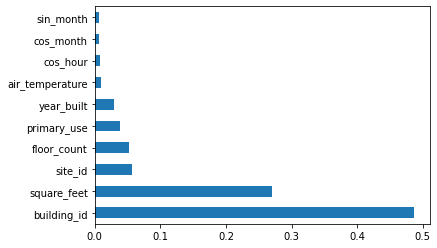

In [65]:
#electricity
feat_importances = pd.Series(rndf_models[0].feature_importances_, index=imp_cols)
feat_importances.nlargest(10).plot(kind='barh')

<AxesSubplot:>

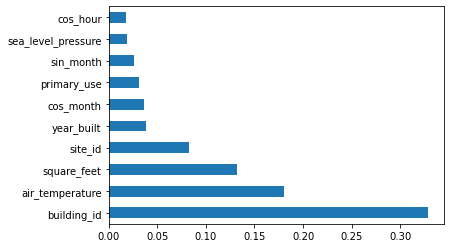

In [72]:
#chilled water
feat_importances = pd.Series(rndf_models[1].feature_importances_, index=imp_cols)
feat_importances.nlargest(10).plot(kind='barh')

<AxesSubplot:>

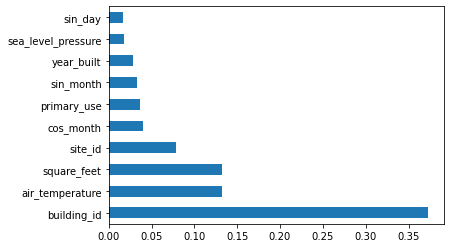

In [67]:
#steam
feat_importances = pd.Series(rndf_models[2].feature_importances_, index=imp_cols)
feat_importances.nlargest(10).plot(kind='barh')

<AxesSubplot:>

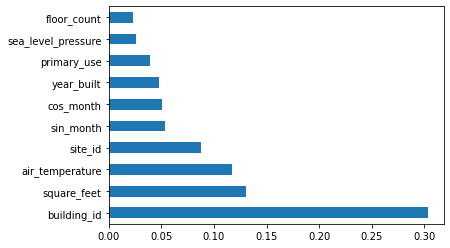

In [68]:
#hot water
feat_importances = pd.Series(rndf_models[3].feature_importances_, index=imp_cols)
feat_importances.nlargest(10).plot(kind='barh')

- 'building_id' looks quiet important as it describes a diffrent type of building. Each buildig would have diffrent power consumption depending upon building type and living standards.
- 'square feet' and 'floor count' is most important feature in predicting electricity meter. This seems obvoius as more the space and floor count more the fans,lights.
- 'square feet' is most important feature in predicting steam/chilledwater/hotwater meter. This seems obvoius as more the space more the number of Ac's and geysers.
- 'site_id' too is quiet important as it describes a specific region. Each region would have diffrent power consumption depending upon living standards.
- Air_temperature is quiet important in case of predicting steam/hotwater/chilledwater readings, not soo important for electricity resdings. This too is quiet intuative. 